# Exploratory Dataset Analysis

### Package Importing

In [122]:
import pandas as pd
import numpy as np
import pprint

from tqdm import tqdm_notebook as tqdm

# Regular expressions
import re

# Natural Language toolkit

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string

# Language detection package

import pycld2 as cld2


# Countvectorizer from Sklearn

from sklearn.feature_extraction.text import CountVectorizer

# Model
from sklearn.neighbors import KNeighborsClassifier


# Evaluation report
from sklearn.metrics import classification_report


### Dataset importing

In [98]:
file = open("training_set.txt", "r")
print(file.read())


sentence	emotion
I'm too old to be traded in .	6
Mother said you could always tell a lady by her hands .	8
I always said I'd leave off when the time came .	6
He'll be safe with me .	2
Lay off .	1
You tell him to take care of you .	8
I hope so .	4
Why do you want to shut me out in the cold like this ?	6
You taught me a lesson , man .	8
I'll do everything I can to make a success of it .	2
But it was worth it .	5
I hope I never wake up .	6
Alright , here's how it works ....	2
Flo , being a parent is about sharing .	8
He looks like a drunk .	3
... Primitive	3
Hello . - Never , ever pick up the phone .	1
[PERSON] , could I have a word with you ?	4
I'm not resigning my senior partnership the day after what happened , happened , if that's what you're asking .	2
It's OK .	8
Why don't you sit down and try not to waste my time ?	1
Find someone to type this .	8
You're too nice .	8
It's time to update the program and I would like to hear from each one of you .	2
I've lost another man and that bast

In [99]:
data = pd.read_csv("training_set.txt",sep='\t' )
data.head()



,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


In [100]:
## validation set importing

val = open("dev_set.txt", "r")
val = pd.read_csv("dev_set.txt",sep='\t')
val.head(3)


,sentence,emotion
0,What happens to the gold in our safe ?,4
1,Natural to get cold feet .,8
2,"Not very lucky , is he ?",7


###  Label counting

In [101]:
data.groupby('emotion').count()

,sentence
emotion,
1,2999
2,2129
3,1343
4,1442
5,1470
6,1384
7,1138
8,2095


<AxesSubplot:xlabel='emotion'>

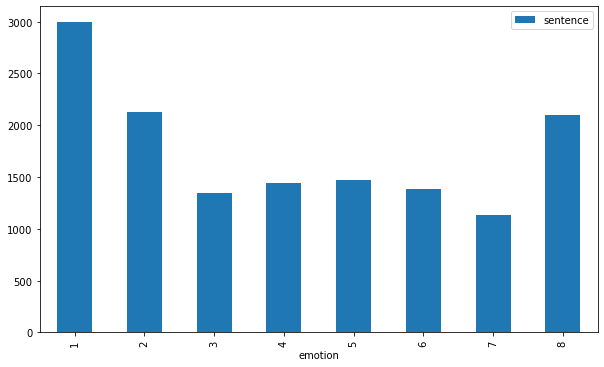

In [102]:
# Plotting the cardinality of the different 'emotion' labels

data.groupby('emotion').count().plot.bar(figsize=(10,6))

In [103]:
## Or by using Professors code - Word count

def label_counter(dataframe, field):
    """
    Function that receives a dataframe and the field whose labels you want to count, and
    returns the amount of examples with those labels in the Pandas dataframe.
    """    
    return dataframe[field].value_counts()

In [104]:
label_counter(data, 'emotion')

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

## Word Counting

In [105]:
def word_counter(text_list):
    """
    Function that receives a list of strings and returns the (absolute) frequency of each word in that list of strings.
    """
    words_in_df = ' '.join(text_list).split()
    
    # Count all words 
    freq = pd.Series(words_in_df).value_counts()
    return freq

In [106]:
word_counter(list(data['sentence']))[:25]

# The majority of the top 25 most frequent words are either ponctuation or stop words

.           10600
,            5738
you          3502
I            3208
to           2862
the          2703
?            2696
a            2320
!            1608
[PERSON]     1386
of           1358
and          1266
me           1195
it           1193
that         1156
in           1083
You           950
is            902
for           847
be            761
this          757
I'm           738
have          727
your          690
my            678
dtype: int64

## Models as benchmark

- **Weaker Baseline**: 
    - Pre-processing: Removing everything but letters, ‘?’ and ‘!’; stemming; stop word removal.
    - CountVectorizer + KNN
    - With Accuracy of 27%
- **Stronger Baseline**:
    - preprocessing
    - CountVectorizer
    - SVC ( Linear Kernel)

# NLP Pipeline - Weaker Baseline

- Pre-processing: Removing everything but letters, ‘?’ and ‘!’; stemming; stop word removal.
    - CountVectorizer + KNN
    - With Accuracy of 27%

## Initial Pre-processing

In [107]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [108]:
# Size of unique stop words

len(stop)

179

In [109]:
# Ponctuation unique characters inside exclude set

len(exclude)

32

In [110]:
data['sentence'][0]

"I'm too old to be traded in ."

### Clean function

- Lower cases
- apply stemmatization/lemmatization 
- Remove numerical data and punctuation
- Remove tags (with beautifulsoup)


(tdqm - Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done)

In [111]:
snowball_stemmer = SnowballStemmer('english')

def clean(text_list, lemmatize, stemmer):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE STOP WORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #REMOVE TAGS
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Text": list_updated}))

In [112]:
# Applying the cleaning function to the 'sentence' column of our dataset
# Lemmer false
# Stemmer true 

updated_data = clean(data['sentence'], lemmatize = False, stemmer = True)

/var/folders/gl/_jrjbthx3mdbjrh_13kh3xm80000gn/T/ipykernel_5585/2514256651.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_list))):


  0%|          | 0/14000 [00:00<?, ?it/s]

In [113]:
# Update the data frame

update_df(data, updated_data)
data.head(3)

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6


## Feature Extraction with bag-of-words

- max_df -> When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

In [114]:
# Defining CV

cv = CountVectorizer(max_df=0.9, binary=True)

In [115]:
X = cv.fit_transform(data["sentence"])
y = np.array(data['emotion'])

In [116]:
X.shape

(14000, 7456)

## Training the model with KNN classifier

In [117]:
modelknn = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute', leaf_size=30, p=2,
                                         metric='cosine', metric_params=None, n_jobs=1)

In [118]:
modelknn.fit(X,y)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_jobs=1,
                     weights='distance')

## Testing the model

### Applying the same pre-processing to the validation set

In [119]:
updated_val = clean(val['sentence'], lemmatize = False, stemmer = True)
update_df(val, updated_val)

/var/folders/gl/_jrjbthx3mdbjrh_13kh3xm80000gn/T/ipykernel_5585/2514256651.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm(range(len(text_list))):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [120]:
# Cv transform no val set

Val = cv.transform(val['sentence'])

In [121]:
predict = modelknn.predict(Val)
y = np.array(val['emotion'])

## Evaluation

In [124]:
print (classification_report(predict, y))

              precision    recall  f1-score   support

           1       0.49      0.35      0.41       292
           2       0.33      0.31      0.32       183
           3       0.04      0.10      0.06        30
           4       0.23      0.32      0.27        75
           5       0.25      0.24      0.24        99
           6       0.20      0.33      0.24        52
           7       0.19      0.21      0.20        85
           8       0.38      0.33      0.35       184

    accuracy                           0.30      1000
   macro avg       0.26      0.27      0.26      1000
weighted avg       0.34      0.30      0.32      1000



## Models as benchmark

- **Weaker Baseline**: 
    - Pre-processing: Removing everything but letters, ‘?’ and ‘!’; stemming; stop word removal.
    - CountVectorizer + KNN
    - With Accuracy of 27%
- **Stronger Baseline**:
    - preprocessing
    - CountVectorizer
    - SVC ( Linear Kernel)


## Checking the present languages in the text - Pycld2 (UNDER CONSTRUCTION)

In [18]:
, , , = cld2.detect((data['sentence'][0]),  returnVectors=True)

(',', ',', '=', "cld2.detect((data['sentence'][0]),", 'returnVectors=True)')